episodic_only
- mean 44.56
- std 1.85

semantic_only
- mean 55.72
- std 1.61

random
- mean 37.64 
- std 2.16

dqn_pretrained (w/o warm_start)
- mean 84.0
- std 6.23

dqn (w/o warm_start)
- mean 69
- std 8.67


In [34]:
from explicit_memory.utils import read_yaml
from glob import glob

test_scores = {"pre_trained": [], "not_pre_trained": []}
for foo in glob("./training_results/refactoring/dqn/*/results.yaml"):
    results = read_yaml(foo)
    test_scores["not_pre_trained"].append(results["test_score"])

for foo in glob("./training_results/refactoring/dqn_pretrained/*/results.yaml"):
    results = read_yaml(foo)
    test_scores["pre_trained"].append(results["test_score"])

In [37]:
import numpy as np

np.mean([foo["mean"] for foo in test_scores["pre_trained"]]), np.std(
    [foo["mean"] for foo in test_scores["pre_trained"]]
)

(84.0, 6.234099774626645)

In [38]:
np.mean([foo["mean"] for foo in test_scores["not_pre_trained"]]), np.std(
    [foo["mean"] for foo in test_scores["not_pre_trained"]]
)

(69.32000000000001, 8.666810255220774)

In [31]:
results["test_score"]

{'mean': 63.8, 'std': 9.05}

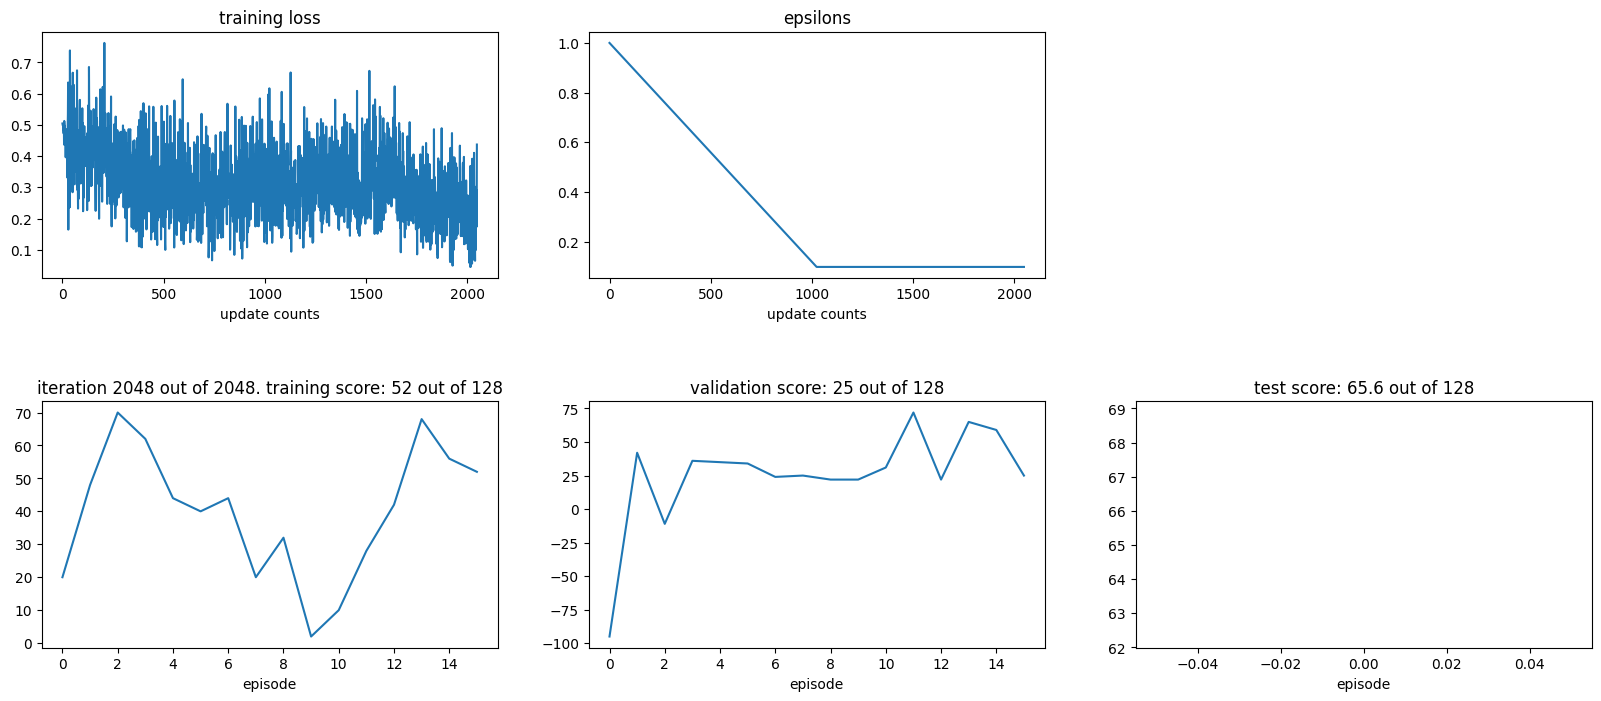

In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

from agent import DQNAgent

all_params = {
    "env_str": "room_env:RoomEnv-v1",
    "max_epsilon": 1.0,
    "min_epsilon": 0.1,
    "epsilon_decay_until": 128 * 8,
    "gamma": 0.65,
    "capacity": {"episodic": 16, "semantic": 16, "short": 1},
    "nn_params": {
        "hidden_size": 64,
        "num_layers": 2,
        "n_actions": 3,
        "embedding_dim": 32,
        "include_human": "sum",
    },
    "num_iterations": 128 * 16,
    "replay_buffer_size": 16 * 16,
    "warm_start": 16 * 16,
    "batch_size": 16,
    "target_update_rate": 10,
    "pretrain_semantic": False,
    "run_validation": True,
    "run_test": True,
    "num_samples_for_results": 10,
    "train_seed": 5,
    "plotting_interval": 10,
    "device": "cpu",
    "test_seed": 0,
}

agent = DQNAgent(**all_params)
agent.train()


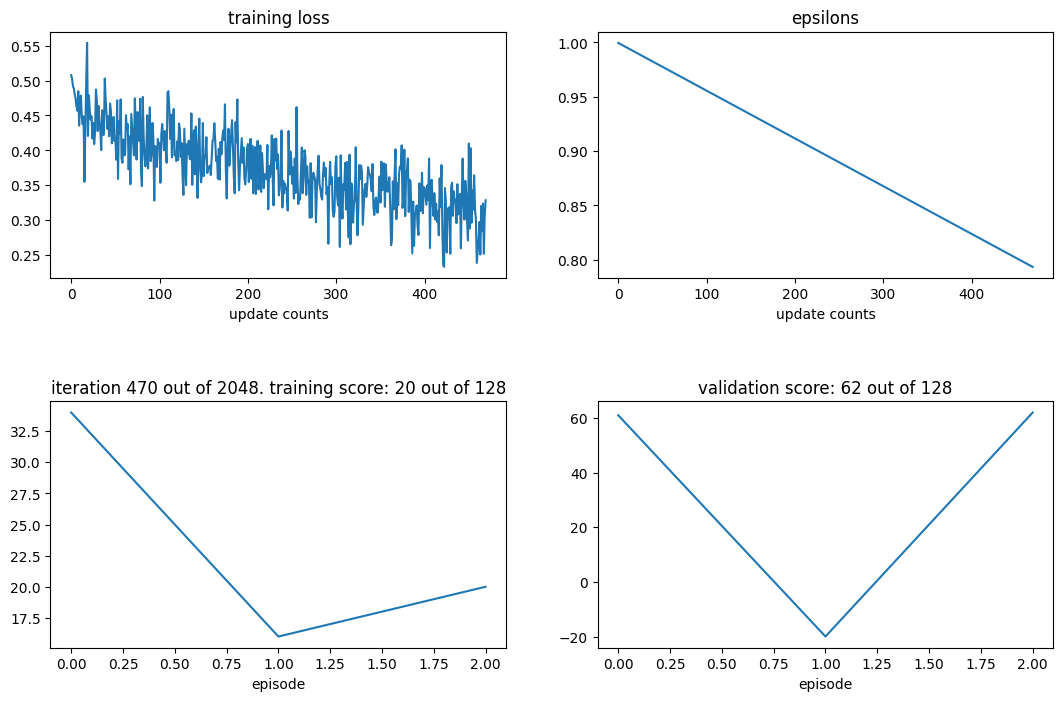

In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

from agent import DQNAgent

for pretrain_semantic in [False, True]:
    for test_seed in [0, 1, 2, 3, 4]:
        # parameters
        all_params = {
            "env_str": "room_env:RoomEnv-v1",
            "max_epsilon": 1.0,
            "min_epsilon": 0.1,
            "epsilon_decay_until": 128 * 16,
            "gamma": 0.65,
            "capacity": {"episodic": 16, "semantic": 16, "short": 1},
            "nn_params": {
                "hidden_size": 64,
                "num_layers": 2,
                "n_actions": 3,
                "embedding_dim": 32,
                "include_human": "sum",
            },
            "num_iterations": 128 * 16,
            "replay_buffer_size": 128 * 16,
            # "warm_start": 1024 * 128,
            "warm_start": 128 * 16,
            # "batch_size": 1024,
            "batch_size": 128,
            "target_update_rate": 10,
            "pretrain_semantic": pretrain_semantic,
            "run_validation": True,
            "run_test": True,
            "num_samples_for_results": 10,
            "train_seed": test_seed + 5,
            "plotting_interval": 10,
            "device": "cpu",
            "test_seed": test_seed,
        }

        agent = DQNAgent(**all_params)
        agent.train()


In [ ]:
import logging

logger = logging.getLogger()
logger.disabled = True

from agent import DQNAgent

for pretrain_semantic in [False, True]:
    for test_seed in [0, 1, 2, 3, 4]:
        # parameters
        all_params = {
            "env_str": "room_env:RoomEnv-v1",
            "max_epsilon": 1.0,
            "min_epsilon": 0.1,
            "epsilon_decay_until": 128 * 16,
            "gamma": 0.65,
            "capacity": {"episodic": 16, "semantic": 16, "short": 1},
            "nn_params": {
                "hidden_size": 64,
                "num_layers": 2,
                "n_actions": 3,
                "embedding_dim": 32,
                "include_human": "sum",
            },
            "num_iterations": 128 * 16,
            "replay_buffer_size": 128 * 16,
            "warm_start": 128 * 16,
            "batch_size": 128 * 16,
            "target_update_rate": 10,
            "pretrain_semantic": pretrain_semantic,
            "run_validation": True,
            "run_test": True,
            "num_samples_for_results": 10,
            "train_seed": test_seed + 5,
            "plotting_interval": 10,
            "device": "cpu",
            "test_seed": test_seed,
        }

        agent = DQNAgent(**all_params)
        agent.train()


In [ ]:
import logging

logger = logging.getLogger()
logger.disabled = True

from tqdm.auto import tqdm

from agent import HandcraftedAgent

for policy in tqdm(["random", "episodic_only", "semantic_only"]):
    for test_seed in [0, 1, 2, 3, 4]:
        all_params = {
            "env_str": "room_env:RoomEnv-v1",
            "policy": policy,
            "num_samples_for_results": 10,
            "seed": test_seed,
        }
        if policy == "random":
            all_params["capacity"] = {"episodic": 16, "semantic": 16, "short": 1}
        elif policy == "episodic_only":
            all_params["capacity"] = {"episodic": 32, "semantic": 0, "short": 1}
        else:
            all_params["capacity"] = {"episodic": 0, "semantic": 32, "short": 1}

        all_params["seed"] = test_seed
        agent = HandcraftedAgent(**all_params)
        agent.test()

In [ ]:
from glob import glob
import yaml
import numpy as np

results = glob("./training_results/refactoring/episodic_only_agent/*/results.yaml")
scores = []
for file in results:
    with open(file, "r") as f:
        results = yaml.load(f, Loader=yaml.FullLoader)

    scores.append(results["test_score"]["mean"])
print(np.mean(scores), np.std(scores))

In [ ]:
from glob import glob
import yaml
import numpy as np

results = glob("./training_results/refactoring/semantic_only_agent/*/results.yaml")
scores = []
for file in results:
    with open(file, "r") as f:
        results = yaml.load(f, Loader=yaml.FullLoader)

    scores.append(results["test_score"]["mean"])
print(np.mean(scores), np.std(scores))

In [ ]:
from glob import glob
import yaml
import numpy as np

results = glob("./training_results/refactoring/random_agent/*/results.yaml")
scores = []
for file in results:
    with open(file, "r") as f:
        results = yaml.load(f, Loader=yaml.FullLoader)

    scores.append(results["test_score"]["mean"])
print(np.mean(scores), np.std(scores))

In [ ]:
# heights: 50.4, stds: 8.429
# heights: 58.0, stds: 9.381
# heights: 33.8, stds: 9.569
# heights: 89.32000122070312, stds: 4.021143669546528
# heights: 110.71999969482422, stds: 3.5181795198362273